In [447]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import DataLoader
from thermography_dataset_one_layer import ThermDataset
from sklearn.model_selection import train_test_split
%matplotlib inline

In [448]:
args = {'lr':0.01,
        'epochs':1000,
        'noise':0,
        'train size':0.7,
        'spec scale':10**12
        }

In [449]:
def df_to_tensor(df):
    return torch.tensor(df.values, dtype=torch.float32)

# Prepare Data

In [450]:
df = pd.read_excel('combined_data.xlsx')

In [451]:
X = df.iloc[:,11:]
y = df.iloc[:,:11]

In [452]:
X = X.apply(lambda x: x*args['spec scale'])

In [453]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=args['train size'], random_state=101)

In [454]:
X_train.index = range(len(X_train))

In [455]:
X_train

,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,0.000005,...,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008,0.000008
0,0.532133,0.638418,0.726998,0.802254,0.866701,0.933640,1.000501,1.067615,1.134905,1.202684,...,5.303224,5.372908,5.430458,5.471816,5.494759,5.486708,5.423339,5.281082,5.076630,4.888354
1,0.414041,0.457451,0.496973,0.537416,0.575507,0.616503,0.658605,0.701921,0.746277,0.791765,...,4.100028,4.163747,4.216513,4.255809,4.280443,4.280814,4.237858,4.132937,3.978863,3.836942
2,0.465971,0.535950,0.599500,0.657984,0.709998,0.764922,0.820523,0.876953,0.934031,0.991913,...,4.857763,4.927424,4.984310,5.025386,5.049202,5.044452,4.988772,4.860395,4.674584,4.503457
3,0.383691,0.450965,0.514631,0.572481,0.623304,0.676948,0.731329,0.786481,0.842163,0.898461,...,4.744066,4.813846,4.870592,4.911579,4.935582,4.931638,4.877883,4.753013,4.571928,4.405149
4,0.202562,0.201751,0.203200,0.210987,0.221130,0.232812,0.245369,0.258871,0.273278,0.288644,...,1.673267,1.706698,1.737154,1.762956,1.783029,1.793023,1.784698,1.749866,1.693567,1.641708
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1535,0.289292,0.303189,0.315865,0.332897,0.350998,0.370787,0.391281,0.412664,0.434948,0.458279,...,2.185162,2.223102,2.258088,2.287536,2.309717,2.318868,2.304381,2.255814,2.179809,2.109786
1536,0.381550,0.470170,0.548909,0.615927,0.673070,0.732666,0.792570,0.852905,0.913487,0.974471,...,5.003251,5.074765,5.132710,5.174146,5.197733,5.191909,5.133690,5.000708,4.808701,4.631874
1537,0.453996,0.544847,0.620312,0.684716,0.740257,0.798081,0.856012,0.914347,0.973024,1.032310,...,4.783330,4.849700,4.904975,4.945541,4.969423,4.965237,4.910910,4.784997,4.602506,4.434433
1538,0.325858,0.330976,0.332963,0.341853,0.353758,0.367173,0.381218,0.396176,0.412134,0.429284,...,1.653589,1.682302,1.710493,1.735484,1.755333,1.765342,1.757317,1.723186,1.667904,1.616983


# Design Models

In [456]:
class Net(nn.Module):
    def __init__(self, input_size, output_size):
        super(Net, self).__init__()
        self.lin1 = nn.Linear(input_size, 45)
        self.lin2 = nn.Linear(45, 60)
        self.lin3 = nn.Linear(60, 75)
        self.lin4 = nn.Linear(75, 60)
        self.lin_fin = nn.Linear(60, output_size)


    def forward(self, x):
        x = F.leaky_relu(self.lin1(x))
        x = F.leaky_relu(self.lin2(x))
        x = F.leaky_relu(self.lin3(x))
        x = F.leaky_relu(self.lin4(x))
        x = self.lin_fin(x)
        return x

In [457]:
n_samples = len(X_train)
input_size = 66
output_size = 1

# store models in descending order (11, 10, 9...)
models = []
for i in range(11):
    models.append(Net(input_size+i, output_size))

# Training Loops

In [458]:
learning_rate = args['lr']
criterion = nn.MSELoss()

In [459]:
best_losses = []

for i in range(11):
    best_loss = np.inf
    best_epoch = 0

    print(f'Layer {11-i}')

    optimizer = torch.optim.Adam(models[i].parameters(), lr=learning_rate)
    model = models[i]

    inputs = df_to_tensor(X_train)
    outputs = df_to_tensor(y_train.iloc[:,10-i]).reshape(-1,1)

    for epoch in range(args['epochs']):
        # empty gradients
        optimizer.zero_grad()

        # forward pass
        pred = model(inputs)

        # loss
        loss = criterion(pred, outputs)

        # backward pass
        loss.backward()
        
        # update
        optimizer.step()

        if (epoch+1) % int(args['epochs']/10) == 0:
            print(f'epoch: {epoch+1}, loss = {loss}')

        if loss < best_loss:
            best_loss = loss
            best_epoch = epoch + 1

    best_losses.append(best_loss.item())
    
    X_train[f'layer {11-i} predictions'] = pd.DataFrame(pred.detach().numpy())
    print(f'best loss: {best_loss} in epoch {best_epoch}\n')


Layer 11


epoch: 100, loss = 2752.0791015625
epoch: 200, loss = 7.036067962646484
epoch: 300, loss = 69.91508483886719
epoch: 400, loss = 4.636088848114014
epoch: 500, loss = 50.512393951416016
epoch: 600, loss = 3.556549310684204
epoch: 700, loss = 1555.991455078125
epoch: 800, loss = 2.9847617149353027
epoch: 900, loss = 2.350904703140259
epoch: 1000, loss = 2.598435401916504
best loss: 2.2616794109344482 in epoch 920

Layer 10
epoch: 100, loss = 234.97190856933594
epoch: 200, loss = 139.09730529785156
epoch: 300, loss = 34.00491714477539
epoch: 400, loss = 30.07916259765625
epoch: 500, loss = 28.405794143676758
epoch: 600, loss = 27.220569610595703
epoch: 700, loss = 26.901823043823242
epoch: 800, loss = 114.8257064819336
epoch: 900, loss = 22.061317443847656
epoch: 1000, loss = 41.66435623168945
best loss: 21.14292335510254 in epoch 978

Layer 9
epoch: 100, loss = 55.565269470214844
epoch: 200, loss = 37.12224578857422
epoch: 300, loss = 34.95804977416992
epoch: 400, loss = 34.57175445556640

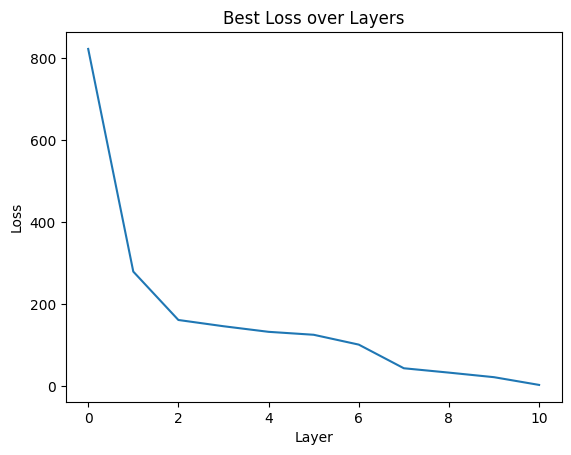

In [460]:
best_losses.reverse()
plt.plot(best_losses)

plt.title("Best Loss over Layers")
plt.xlabel("Layer")
plt.ylabel("Loss")
plt.show()

# Testing

In [461]:
def get_predictions(X_test):
    df = X_test

    for i in range(11):
        inputs = df_to_tensor(df)
        pred = models[i](inputs)
        df[f'layer {11-i} predictions'] = pd.DataFrame(pred.detach().numpy())

    return df.loc[:, 'layer 11 predictions':'layer 1 predictions']

In [462]:
get_predictions(X_test)

,layer 11 predictions,layer 10 predictions,layer 9 predictions,layer 8 predictions,layer 7 predictions,layer 6 predictions,layer 5 predictions,layer 4 predictions,layer 3 predictions,layer 2 predictions,layer 1 predictions
1124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
235,311.239990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
585,367.628479,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1469,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2066,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1593,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1831,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
737,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2098,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
